In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [38]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import lightgbm as lgb

In [39]:
BTC_BUSD = pd.read_parquet("Data/BTC-BUSD.parquet")
BTC_BUSD.head(15)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2019-09-19 10:02:00,9881.429688,9881.429688,9881.429688,9881.429688,0.001113,10.998032,1,0.001113,10.998032
2019-09-19 10:03:00,9881.429688,9881.429688,9881.429688,9881.429688,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:04:00,9878.360352,9878.360352,9878.360352,9878.360352,0.012940,127.825981,1,0.012940,127.825981
2019-09-19 10:05:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:06:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:07:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:08:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:09:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:10:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000


In [40]:
# Check if there is any NaN values
for col_name, _ in BTC_BUSD.iteritems():
    if len(BTC_BUSD[BTC_BUSD[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(BTC_BUSD[BTC_BUSD[col_name].isna()])))

In [41]:
# Data clean and related analysis
BTC_BUSD_copy = BTC_BUSD.copy()
BTC_BUSD_copy.reset_index(drop=False, inplace=True)

Text(0, 0.5, 'BTC-BUSD')

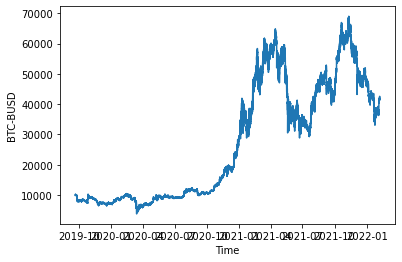

In [42]:
plt.plot(BTC_BUSD_copy['open_time'], BTC_BUSD_copy['open'])
plt.xlabel('Time')
plt.ylabel('BTC-BUSD')

In [50]:
# Option1: use price 5 minutes later
# Set target predict price (5 minutes later)
target_price = BTC_BUSD_copy['open'].shift(-5, fill_value=BTC_BUSD['open'][-1]).rename("price_5_min_later")
target_price

0           9878.360352
1           9878.360352
2           9878.360352
3           9878.360352
4           9878.360352
               ...     
1252557    42416.441406
1252558    42416.441406
1252559    42416.441406
1252560    42416.441406
1252561    42416.441406
Name: price_5_min_later, Length: 1252562, dtype: float32

In [44]:
# Option2 : use window sliding mean
window = 5
open_price = list(BTC_BUSD_copy['open'].values)
open_price = open_price + [open_price[-1]] * (window - 1)
print(len(open_price))
target_price = pd.Series(np.convolve(open_price, np.ones(window), mode='valid') / window,  name='mean_price_in_future_5_minutes')
target_price

1252566


0           9879.588086
1           9878.974219
2           9878.360352
3           9878.360352
4           9878.360352
               ...     
1252557    42420.134375
1252558    42414.886719
1252559    42419.060937
1252560    42420.392969
1252561    42416.441406
Name: mean_price_in_future_5_minutes, Length: 1252562, dtype: float64

In [51]:
dataset = pd.concat([BTC_BUSD_copy, target_price], axis=1)
dataset.head()

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,price_5_min_later
0,2019-09-19 10:02:00,9881.429688,9881.429688,9881.429688,9881.429688,0.001113,10.998032,1,0.001113,10.998032,9878.360352
1,2019-09-19 10:03:00,9881.429688,9881.429688,9881.429688,9881.429688,0.000000,0.000000,0,0.000000,0.000000,9878.360352
2,2019-09-19 10:04:00,9878.360352,9878.360352,9878.360352,9878.360352,0.012940,127.825981,1,0.012940,127.825981,9878.360352
3,2019-09-19 10:05:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000,9878.360352
4,2019-09-19 10:06:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000,9878.360352


In [58]:
class LightGBM_model():
    def __init__(self, **kwargs):
        self.boosting_type = kwargs.get('boosting_type', 'gbdt')
        self.num_leaves = kwargs.get('num_leaves', 31)
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.subsample_for_bin = kwargs.get('subsample_for_bin', 200000)
        self.max_depth = kwargs.get('max_depth', 3)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.min_split_gain = kwargs.get('min_split_gain', 0.0)
        self.min_child_samples = kwargs.get('min_child_samples', 20)
        self.reg_alpha = kwargs.get('reg_alpha', 0)
        self.reg_lambda = kwargs.get('reg_lambda', 1)
        

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=5):

        print('Finding best hyper-parameters for the model...')
        estimator = lgb.LGBMRegressor(boosting_type=self.boosting_type, num_leaves=self.num_leaves, 
                                      max_depth=self.max_depth, learning_rate=self.learning_rate, 
                                      n_estimators=self.n_estimators, subsample_for_bin=self.subsample_for_bin, 
                                      min_split_gain=self.min_split_gain, min_child_samples=self.min_child_samples, 
                                      subsample=self.subsample, reg_alpha=self.reg_alpha, 
                                      reg_lambda=self.reg_lambda, n_jobs=-1)
        lgb_try = GridSearchCV(estimator=estimator, param_grid=param_space, cv=KFold(n_splits=num_sets, shuffle=True), scoring='neg_mean_absolute_error')
        grid_result = lgb_try.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']
        
        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = lgb_try.best_params_
        print('Best params set:', best_params)
        print('Minimum mean absolute error:', -np.max(means))
        print('---------------------------------------------------')
        self.boosting_type = best_params.get('boosting_type', self.boosting_type)
        self.num_leaves = best_params.get('num_leaves', self.num_leaves)
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.subsample = best_params.get('subsample', self.subsample)
        self.subsample_for_bin = best_params.get('subsample_for_bin', self.subsample_for_bin)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.min_split_gain = best_params.get('min_split_gain', self.min_split_gain)
        self.min_child_samples = best_params.get('min_child_samples', self.min_child_samples)
        self.reg_alpha = best_params.get('reg_alpha', self.reg_alpha)
        self.reg_lambda = best_params.get('reg_lambda', self.reg_lambda)

        return 


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.boosting_type = params.get('boosting_type', self.boosting_type)
            self.num_leaves = params.get('num_leaves', self.num_leaves)
            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.subsample = params.get('subsample', self.subsample)
            self.subsample_for_bin = params.get('subsample_for_bin', self.subsample_for_bin)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.min_split_gain = params.get('min_split_gain', self.min_split_gain)
            self.min_child_samples = params.get('min_child_samples', self.min_child_samples)
            self.reg_alpha = params.get('reg_alpha', self.reg_alpha)
            self.reg_lambda = params.get('reg_lambda', self.reg_lambda)

        lgb_reg = lgb.LGBMRegressor(boosting_type=self.boosting_type, num_leaves=self.num_leaves, 
                                      max_depth=self.max_depth, learning_rate=self.learning_rate, 
                                      n_estimators=self.n_estimators, subsample_for_bin=self.subsample_for_bin, 
                                      min_split_gain=self.min_split_gain, min_child_samples=self.min_child_samples, 
                                      subsample=self.subsample, reg_alpha=self.reg_alpha, 
                                      reg_lambda=self.reg_lambda, n_jobs=- 1)
        # 10折交叉验证
        sk = KFold(n_splits=5, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            lgb_reg.fit(train_x, train_y)
            pred_train_lgb = lgb_reg.predict(train_x)
            pred_val_lgb = lgb_reg.predict(val_x)

            score_train = mean_absolute_error(train_y, pred_train_lgb)
            scores_train.append(score_train)
            score_val = mean_absolute_error(val_y, pred_val_lgb)
            scores_val.append(score_val)

        print('Train mean absolute error:', np.mean(scores_train))
        print('Val mean absolute error:', np.mean(scores_val))

        return lgb_reg

    @staticmethod
    def save_model(model):

        print('Saving model...')
        folder_path = os.getcwd()
        model_path = folder_path + '\\lgb_model.pkl'
        joblib.dump(model, model_path)
        print('Model saved.')

    @staticmethod
    def predict_with_model(model, x_test):
        y_test_pred = model.predict(x_test)

        return y_test_pred




In [63]:
N = len(dataset)
# Train data range
start_point = int(0.01*N)
train_length = int(0.7*N)

# Test with data in the following 24 hours
test_length = 60 * 24


X_train = dataset.iloc[start_point:start_point + train_length, 1:-1]
Y_train = dataset.iloc[start_point:start_point + train_length, -1]



X_test = dataset.iloc[start_point + train_length : start_point + train_length + test_length, 1:-1]
Y_test = dataset.iloc[start_point + train_length : start_point + train_length + test_length, -1]
print("Train range: ", start_point, " - ", start_point + train_length)
print("Train length:", train_length)
print('='*20)
print("Train range: ", start_point, " - ", start_point + train_length)
print("Train length:", train_length)

Train range:  12525  -  889318
Train length: 876793


In [60]:
# With hyperparameter grid search

task = LightGBM_model()

params = {'learning_rate': [0.03, 0.1, 0.3],
            'n_estimators': [100, 200]

}

lgb_reg = task.build_model(X_train, Y_train, params, grid_search=True)
# mymodel.save_model(lgb_reg)
Y_test_pred = task.predict_with_model(lgb_reg, X_test)
print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

Finding best hyper-parameters for the model...
-694.538141  with:   {'learning_rate': 0.03, 'n_estimators': 100}
-81.252182  with:   {'learning_rate': 0.03, 'n_estimators': 200}
-85.474840  with:   {'learning_rate': 0.1, 'n_estimators': 100}
-79.177867  with:   {'learning_rate': 0.1, 'n_estimators': 200}
-83.330464  with:   {'learning_rate': 0.3, 'n_estimators': 100}
-72.033305  with:   {'learning_rate': 0.3, 'n_estimators': 200}
Best params set: {'learning_rate': 0.3, 'n_estimators': 200}
Minimum mean absolute error: 72.0333045844342
---------------------------------------------------
Train mean absolute error: 71.84389054223554
Val mean absolute error: 72.1169532903368
Test mean absolute error: 127.040036


In [56]:
# Without hyperparameter grid search

task = LightGBM_model()

params = {'learning_rate': 0.1,
               'n_estimators': 100

}

lgb_reg = task.build_model(X_train, Y_train, params, grid_search=False)
# mymodel.save_model(lgb_reg)
Y_test_pred = task.predict_with_model(lgb_reg, X_test)
print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

Train mean absolute error: 85.60034814335448
Val mean absolute error: 85.7691760208708
Test mean absolute error: 133.576918


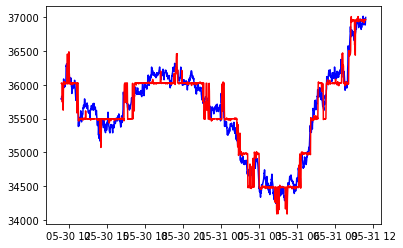

In [61]:
# plt.plot(dataset['open_time'][start_point : start_point + train_length], Y_train, 'g')
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], Y_test, 'b')
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], Y_test_pred, 'r')